## Anomaly detection on time series dataset with Facebook Prophet
#### The data is from a field bus of a building automation system. Apart from heating, ventilation and airconditioning as well as lighting and shading, critical services such as fire alarm or access control systems are added to building automation. 

### Import of all necessary library

In [296]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import plotly.express as px
from prophet import Prophet
from prophet.serialize import model_to_json, model_from_json

mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False

dataset_name = "3.4.26"

### Tolerence level can be changed according to the necessity of how it sensitive the anomaly system is. Generally the number should be between 1 to 3.5. The number can be also higher. But that means that the model is bad at predicting and should be changed. The higher the number the less sensative the anomaly detection is

In [297]:
tolerence_level = 1

In [298]:
df = pd.read_csv(dataset_name +".csv")

In [299]:
df

datetime  source_addr
0      2018-11-07 18:00:00            6
1      2018-11-07 19:00:00           14
2      2018-11-07 20:00:00            2
3      2018-11-07 21:00:00            2
4      2018-11-07 22:00:00            0
...                    ...          ...
26085  2021-10-29 15:00:00           16
26086  2021-10-29 16:00:00           16
26087  2021-10-29 17:00:00           20
26088  2021-10-29 18:00:00           20
26089  2021-10-29 19:00:00            6

[26090 rows x 2 columns]

In [300]:

df['datetime']=pd.to_datetime(df['datetime'])

In [301]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26090 entries, 0 to 26089
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   datetime     26090 non-null  datetime64[ns]
 1   source_addr  26090 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 407.8 KB


In [302]:
df.head()

datetime  source_addr
0 2018-11-07 18:00:00            6
1 2018-11-07 19:00:00           14
2 2018-11-07 20:00:00            2
3 2018-11-07 21:00:00            2
4 2018-11-07 22:00:00            0

In [303]:
df

datetime  source_addr
0     2018-11-07 18:00:00            6
1     2018-11-07 19:00:00           14
2     2018-11-07 20:00:00            2
3     2018-11-07 21:00:00            2
4     2018-11-07 22:00:00            0
...                   ...          ...
26085 2021-10-29 15:00:00           16
26086 2021-10-29 16:00:00           16
26087 2021-10-29 17:00:00           20
26088 2021-10-29 18:00:00           20
26089 2021-10-29 19:00:00            6

[26090 rows x 2 columns]

### Plotting the whole dataset to see what we are working with

In [304]:
fig = px.line(df.reset_index(), x='datetime', y='source_addr', title='Whole Dataset')

fig.update_xaxes(
    rangeslider_visible=True,
)
fig.show()

### Due to Covid 19, the building was closed. We can see that from the data above. We have to avoid those vacant data to make sure our model works perfectly  

### Facebook Prophet takes two parameter "ds" which is time, and "y" that is what we are trying to predict.

In [305]:
df_final=df.reset_index()[['datetime','source_addr']].rename({'datetime':'ds','source_addr':'y'}, axis='columns')


In [306]:
df_final = df_final[(df_final['ds'] >= '2019-07-19') & (df_final['ds'] <= '2021-10-29')]



### Splitting the dataset to train and test part. We will train the dataset with the splitted data but we will plot the predicted data on the whole dataset

In [307]:
train=df_final[(df_final['ds'] >= '2019-07-19') & (df_final['ds'] <= '2020-12-14')]
test=df_final[(df_final['ds'] >= '2020-12-15') & (df_final['ds'] <= '2021-10-29')]

In [308]:
train.shape
train

ds   y
6078  2019-07-19 00:00:00  16
6079  2019-07-19 01:00:00   8
6080  2019-07-19 02:00:00   8
6081  2019-07-19 03:00:00   4
6082  2019-07-19 04:00:00   8
...                   ...  ..
18410 2020-12-13 20:00:00   0
18411 2020-12-13 21:00:00   0
18412 2020-12-13 22:00:00   0
18413 2020-12-13 23:00:00   0
18414 2020-12-14 00:00:00   0

[12337 rows x 2 columns]

In [309]:
test.shape

(7633, 2)

In [310]:
test

ds   y
18438 2020-12-15 00:00:00   0
18439 2020-12-15 01:00:00   0
18440 2020-12-15 02:00:00   0
18441 2020-12-15 03:00:00   4
18442 2020-12-15 04:00:00  12
...                   ...  ..
26066 2021-10-28 20:00:00   0
26067 2021-10-28 21:00:00   0
26068 2021-10-28 22:00:00   0
26069 2021-10-28 23:00:00   0
26070 2021-10-29 00:00:00   0

[7633 rows x 2 columns]

### Initializing Prophet

In [311]:
m = Prophet(interval_width=0.95)
m.add_country_holidays(country_name='DE')

In [312]:

m.fit(train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


### Making 5000 hours of new prediction

In [313]:
future = m.make_future_dataframe(periods=10000,freq='H', include_history = True)
future

ds
0     2019-07-19 00:00:00
1     2019-07-19 01:00:00
2     2019-07-19 02:00:00
3     2019-07-19 03:00:00
4     2019-07-19 04:00:00
...                   ...
22332 2022-02-03 12:00:00
22333 2022-02-03 13:00:00
22334 2022-02-03 14:00:00
22335 2022-02-03 15:00:00
22336 2022-02-03 16:00:00

[22337 rows x 1 columns]

### The predict method gives us three values. "yhat" the predicted value. Because the predicted value is not perfect and there are uncertainity. Two more values are given. "yhat_upper" and "yhat_lower" which gives the upper and lower uncertainity level

In [314]:
forecast = m.predict(future)    
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds       yhat  yhat_lower  yhat_upper
22332 2022-02-03 12:00:00  14.456690  -81.472320  106.424787
22333 2022-02-03 13:00:00  14.317330  -85.489855  107.988348
22334 2022-02-03 14:00:00  14.786703  -85.259795  107.175722
22335 2022-02-03 15:00:00  15.578783  -84.216350  112.643856
22336 2022-02-03 16:00:00  15.926062  -83.578128  109.284809

In [315]:

results= pd.concat([df_final.set_index('ds')['y'],forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']]],axis=1)



<AxesSubplot:xlabel='ds'>

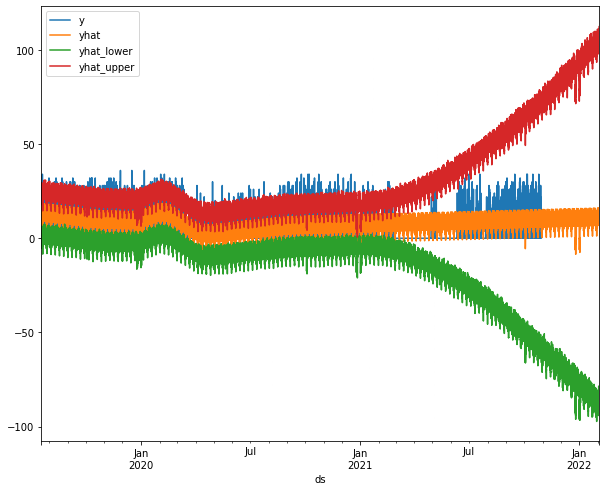

In [316]:
results.plot()

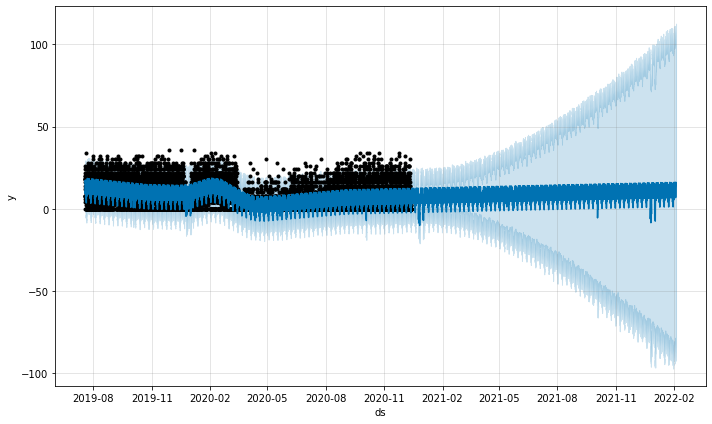

In [317]:

fig1 = m.plot(forecast)

### The model also decomposes the data to show daily, weekly, monthly and yearly trend. 

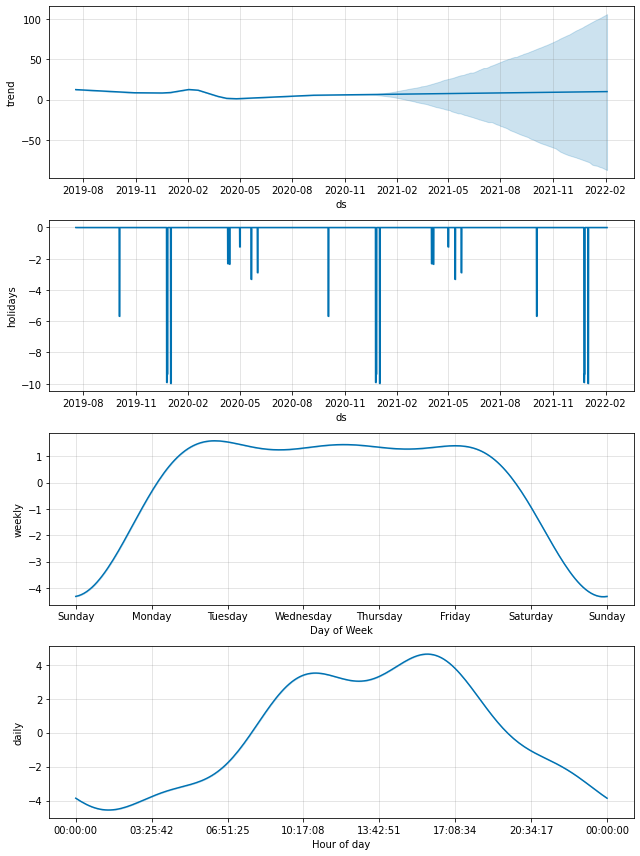

In [318]:
comp=m.plot_components(forecast)

In [319]:
results

y       yhat  yhat_lower  yhat_upper
ds                                                          
2019-07-19 00:00:00  16.0   9.977059   -1.561314   20.699058
2019-07-19 01:00:00   8.0   9.353768   -1.843433   21.191156
2019-07-19 02:00:00   8.0   9.349843   -1.620258   21.435986
2019-07-19 03:00:00   4.0   9.805538   -1.741690   21.502361
2019-07-19 04:00:00   8.0  10.304303   -1.635686   22.087701
...                   ...        ...         ...         ...
2022-02-03 12:00:00   NaN  14.456690  -81.472320  106.424787
2022-02-03 13:00:00   NaN  14.317330  -85.489855  107.988348
2022-02-03 14:00:00   NaN  14.786703  -85.259795  107.175722
2022-02-03 15:00:00   NaN  15.578783  -84.216350  112.643856
2022-02-03 16:00:00   NaN  15.926062  -83.578128  109.284809

[22337 rows x 4 columns]

### We will first find the error by, error = y - yhat. The uncertainity as uncertainty = yhat_upper - yhat_lower. Error by, anomaly = "yes" if |error| > tolerence_level * uncertainty, else "no".    

In [320]:
results['error'] = results['y'] - results['yhat']

In [321]:
results["uncertainty"] = results['yhat_upper'] - results['yhat_lower']

In [322]:
results

y       yhat  yhat_lower  yhat_upper     error  \
ds                                                                       
2019-07-19 00:00:00  16.0   9.977059   -1.561314   20.699058  6.022941   
2019-07-19 01:00:00   8.0   9.353768   -1.843433   21.191156 -1.353768   
2019-07-19 02:00:00   8.0   9.349843   -1.620258   21.435986 -1.349843   
2019-07-19 03:00:00   4.0   9.805538   -1.741690   21.502361 -5.805538   
2019-07-19 04:00:00   8.0  10.304303   -1.635686   22.087701 -2.304303   
...                   ...        ...         ...         ...       ...   
2022-02-03 12:00:00   NaN  14.456690  -81.472320  106.424787       NaN   
2022-02-03 13:00:00   NaN  14.317330  -85.489855  107.988348       NaN   
2022-02-03 14:00:00   NaN  14.786703  -85.259795  107.175722       NaN   
2022-02-03 15:00:00   NaN  15.578783  -84.216350  112.643856       NaN   
2022-02-03 16:00:00   NaN  15.926062  -83.578128  109.284809       NaN   

                     uncertainty  
ds                                
2019-07-19 00:00:00    22.260372  
2019-07-19 01:00:00    23.034589  
2019-07-19 02:00:00    23.056244  
2019-07-19 03:00:00    23.244050  
2019-07-19 04:00:00    23.723387  
...                          ...  
2022-02-03 12:00:00   187.897107  
2022-02-03 13:00:00   193.478203  
2022-02-03 14:00:00   192.435517  
2022-02-03 15:00:00   196.860207  
2022-02-03 16:00:00   192.862936  

[22337 rows x 6 columns]

In [323]:
results[results['error'].abs() >  tolerence_level*results['uncertainty']]

y       yhat  yhat_lower  yhat_upper      error  \
ds                                                                        
2019-11-16 13:00:00  32.0   7.925046   -3.913836   19.697935  24.074954   
2019-11-27 18:00:00  36.0  12.138630    0.467267   23.147646  23.861370   
2020-02-02 21:00:00  34.0  10.202777   -1.368170   22.095162  23.797223   
2020-02-09 00:00:00  34.0   4.061392   -7.965013   14.745015  29.938608   
2020-04-09 06:00:00  24.0   0.255890  -11.215668   11.685907  23.744110   
2020-04-29 09:00:00  30.0   4.672547   -6.429244   15.667989  25.327453   
2020-07-16 04:00:00  26.0   1.668391  -10.764602   12.400082  24.331609   
2020-07-24 05:00:00  30.0   2.342164   -8.885340   14.310065  27.657836   
2020-09-17 04:00:00  32.0   3.389987   -8.011970   15.388383  28.610013   
2020-09-24 11:00:00  34.0  10.424845   -1.036334   22.194491  23.575155   
2020-10-01 04:00:00  28.0   3.512025   -8.017091   14.470801  24.487975   
2020-10-05 13:00:00  34.0  10.181555   -1.341527   21.702665  23.818445   
2020-10-07 15:00:00  34.0  11.485892    0.772307   22.829473  22.514108   
2020-10-15 08:00:00  30.0   7.207238   -4.405449   18.083631  22.792762   
2020-10-23 12:00:00  34.0  10.003316   -1.114427   21.564607  23.996684   

                     uncertainty  
ds                                
2019-11-16 13:00:00    23.611771  
2019-11-27 18:00:00    22.680378  
2020-02-02 21:00:00    23.463332  
2020-02-09 00:00:00    22.710028  
2020-04-09 06:00:00    22.901575  
2020-04-29 09:00:00    22.097233  
2020-07-16 04:00:00    23.164684  
2020-07-24 05:00:00    23.195405  
2020-09-17 04:00:00    23.400354  
2020-09-24 11:00:00    23.230825  
2020-10-01 04:00:00    22.487892  
2020-10-05 13:00:00    23.044192  
2020-10-07 15:00:00    22.057166  
2020-10-15 08:00:00    22.489080  
2020-10-23 12:00:00    22.679035

In [324]:
results['anomaly'] = results.apply(lambda x: 'Yes' if(np.abs(x['error']) >  tolerence_level*x['uncertainty']) else 'No', axis=1)

results

y       yhat  yhat_lower  yhat_upper     error  \
ds                                                                       
2019-07-19 00:00:00  16.0   9.977059   -1.561314   20.699058  6.022941   
2019-07-19 01:00:00   8.0   9.353768   -1.843433   21.191156 -1.353768   
2019-07-19 02:00:00   8.0   9.349843   -1.620258   21.435986 -1.349843   
2019-07-19 03:00:00   4.0   9.805538   -1.741690   21.502361 -5.805538   
2019-07-19 04:00:00   8.0  10.304303   -1.635686   22.087701 -2.304303   
...                   ...        ...         ...         ...       ...   
2022-02-03 12:00:00   NaN  14.456690  -81.472320  106.424787       NaN   
2022-02-03 13:00:00   NaN  14.317330  -85.489855  107.988348       NaN   
2022-02-03 14:00:00   NaN  14.786703  -85.259795  107.175722       NaN   
2022-02-03 15:00:00   NaN  15.578783  -84.216350  112.643856       NaN   
2022-02-03 16:00:00   NaN  15.926062  -83.578128  109.284809       NaN   

                     uncertainty anomaly  
ds                                        
2019-07-19 00:00:00    22.260372      No  
2019-07-19 01:00:00    23.034589      No  
2019-07-19 02:00:00    23.056244      No  
2019-07-19 03:00:00    23.244050      No  
2019-07-19 04:00:00    23.723387      No  
...                          ...     ...  
2022-02-03 12:00:00   187.897107      No  
2022-02-03 13:00:00   193.478203      No  
2022-02-03 14:00:00   192.435517      No  
2022-02-03 15:00:00   196.860207      No  
2022-02-03 16:00:00   192.862936      No  

[22337 rows x 7 columns]

### Plotting Anomaly 

In [325]:
fig = px.scatter(results.reset_index(), x='ds', y='y', color='anomaly', title='Anomaly Detection')

fig.update_xaxes(
    rangeslider_visible=True
    
)
fig.show()

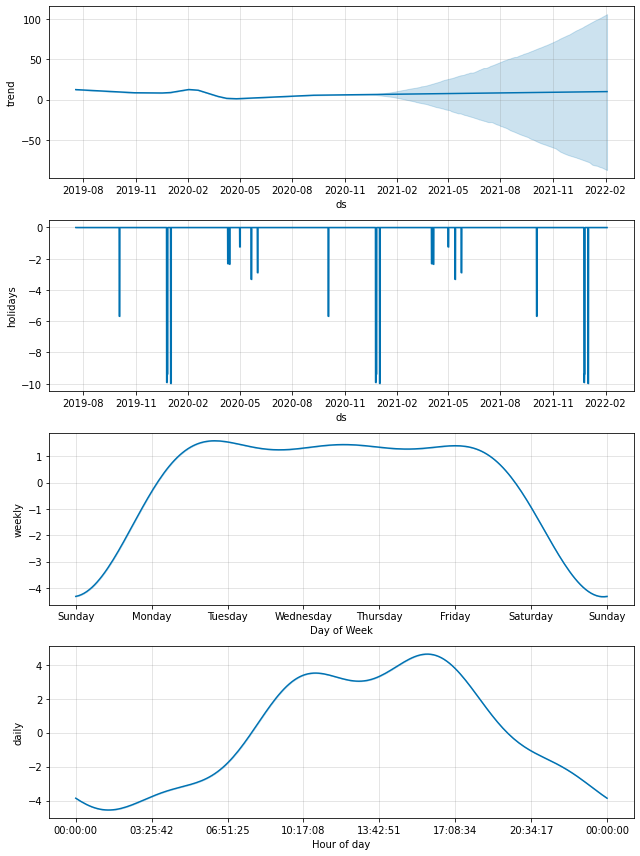

In [326]:
comp=m.plot_components(forecast)

In [327]:
results.query("anomaly == 'Yes'" )

y       yhat  yhat_lower  yhat_upper      error  \
ds                                                                        
2019-11-16 13:00:00  32.0   7.925046   -3.913836   19.697935  24.074954   
2019-11-27 18:00:00  36.0  12.138630    0.467267   23.147646  23.861370   
2020-02-02 21:00:00  34.0  10.202777   -1.368170   22.095162  23.797223   
2020-02-09 00:00:00  34.0   4.061392   -7.965013   14.745015  29.938608   
2020-04-09 06:00:00  24.0   0.255890  -11.215668   11.685907  23.744110   
2020-04-29 09:00:00  30.0   4.672547   -6.429244   15.667989  25.327453   
2020-07-16 04:00:00  26.0   1.668391  -10.764602   12.400082  24.331609   
2020-07-24 05:00:00  30.0   2.342164   -8.885340   14.310065  27.657836   
2020-09-17 04:00:00  32.0   3.389987   -8.011970   15.388383  28.610013   
2020-09-24 11:00:00  34.0  10.424845   -1.036334   22.194491  23.575155   
2020-10-01 04:00:00  28.0   3.512025   -8.017091   14.470801  24.487975   
2020-10-05 13:00:00  34.0  10.181555   -1.341527   21.702665  23.818445   
2020-10-07 15:00:00  34.0  11.485892    0.772307   22.829473  22.514108   
2020-10-15 08:00:00  30.0   7.207238   -4.405449   18.083631  22.792762   
2020-10-23 12:00:00  34.0  10.003316   -1.114427   21.564607  23.996684   

                     uncertainty anomaly  
ds                                        
2019-11-16 13:00:00    23.611771     Yes  
2019-11-27 18:00:00    22.680378     Yes  
2020-02-02 21:00:00    23.463332     Yes  
2020-02-09 00:00:00    22.710028     Yes  
2020-04-09 06:00:00    22.901575     Yes  
2020-04-29 09:00:00    22.097233     Yes  
2020-07-16 04:00:00    23.164684     Yes  
2020-07-24 05:00:00    23.195405     Yes  
2020-09-17 04:00:00    23.400354     Yes  
2020-09-24 11:00:00    23.230825     Yes  
2020-10-01 04:00:00    22.487892     Yes  
2020-10-05 13:00:00    23.044192     Yes  
2020-10-07 15:00:00    22.057166     Yes  
2020-10-15 08:00:00    22.489080     Yes  
2020-10-23 12:00:00    22.679035     Yes

## Saving and Loading Model

In [328]:



with open( dataset_name +".json", 'w') as fout:
    json.dump(model_to_json(m), fout)  # Save model

with open(dataset_name +".json", 'r') as fin:
    new_m = model_from_json(json.load(fin))  # Load model
    

### Introducing custom anomaly

In [329]:
df_final.loc[df_final["ds"] == "2021-01-27 00:00:00", "y"] = 30


In [330]:
future = new_m.make_future_dataframe(periods=5000,freq='H',  include_history = True)
forecast = new_m.predict(future)
results= pd.concat([df_final.set_index('ds')['y'],forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']]],axis=1)


In [331]:
results['error'] = results['y'] - results['yhat']
results["uncertainty"] = results['yhat_upper'] - results['yhat_lower']
results[results['error'].abs() >  tolerence_level*results['uncertainty']]
results['anomaly'] = results.apply(lambda x: 'Yes' if(np.abs(x['error']) >  tolerence_level*x['uncertainty']) else 'No', axis=1)



### Plotting Anomaly 

In [332]:
fig = px.scatter(results.reset_index(), x='ds', y='y', color='anomaly', title='Anomaly Detection')

fig.update_xaxes(
    rangeslider_visible=True,
)
fig.show()